## Fraud Analysis

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
fd = pd.read_csv('fraud_detection.csv')

**This dataset has 6362620 rows, 11 columns, where *isFraud* is the targeted variable column.**  
**There are several issues with the data:**
- **The column 'oldbalaceOrg' is missnamed.**
- **The proportion of Fruad and notFraud is too large. (shown below)**

In [3]:
fd.rename(columns={"oldbalanceOrg":"oldbalanceOrig"}, inplace=True)

**There are no Nulls in data.**

In [4]:
fd.isna().any()

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrig    False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

## Exploratory Data Analysis

**From this plot, we can see there are a lot more not fraud transaction than is fraud.**

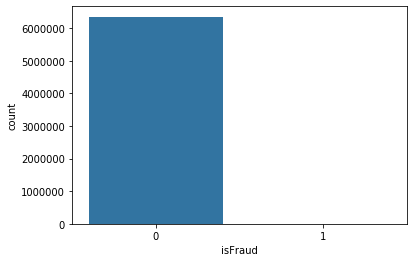

In [5]:
sns.countplot(fd['isFraud'])

In [6]:
print("The portion of isFraud transaction is", round(fd['isFraud'].value_counts()[1]/fd['isFraud'].size*100,2), "%")

The portion of isFraud transaction is 0.13 %


**Other Feature exploratory**

**We can see from the graph that most of the time spans took is within 200-400 hours.**

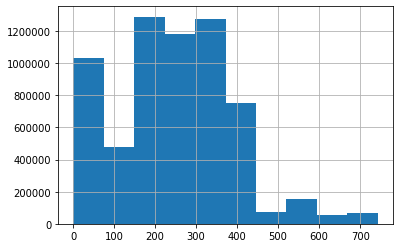

In [7]:
fd['step'].hist()

In [8]:
print("Average amount of time used is", int(fd['step'].mean()/24), 'days')

Average amount of time used is 10 days


**Major of the transaction types are "Payment" and "Cash_OUT"**

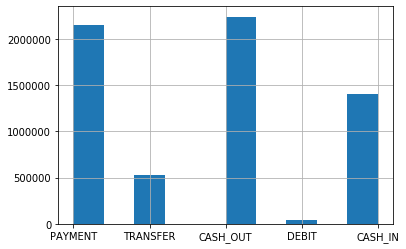

In [9]:
fd['type'].hist()

**The graph shows that there are lots of amount transfer that is 10000000.00 dollars, it's a good point to bear in mind.**

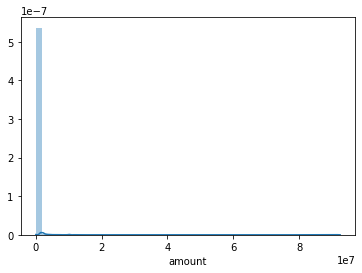

In [10]:
sns.distplot(fd['amount'])

In [11]:
print("The average of amount is", fd['amount'].mean())

The average of amount is 179861.90354912292


**This heatmap shows that:**    
- **Amount has a weak corrlation with old&new Destination Balance but not with old/new Origin Balance.**  
- **There is a slight corrlation between the balance of old/new destination.**  

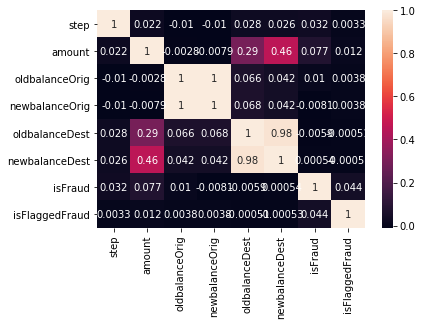

In [12]:
sns.heatmap(fd.corr(), annot=True)

**The weak correlation between amount and new/old balance of Destination is slightly positive, meaning higher Destination balance potentially leads to higher amount.**

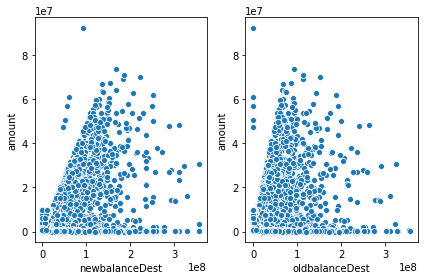

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2)
sns.scatterplot(ax=axes[0], x='newbalanceDest', y='amount', data=fd)
sns.scatterplot(ax=axes[1], x='oldbalanceDest', y='amount', data=fd)
plt.tight_layout()

**This weak correlation stands against high Original Balance leads to high Destination Balance.**  

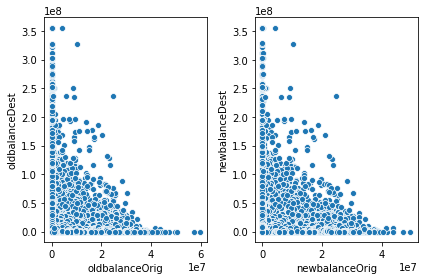

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2)
sns.scatterplot(ax=axes[0], x='oldbalanceOrig', y='oldbalanceDest',data=fd)
sns.scatterplot(ax=axes[1], x='newbalanceOrig', y='newbalanceDest',data=fd)
plt.tight_layout()

**The below two graphs prove that if the transaction amount is huge, there is a high chance that it's a fruad activity, aligned with the sataset description.**  

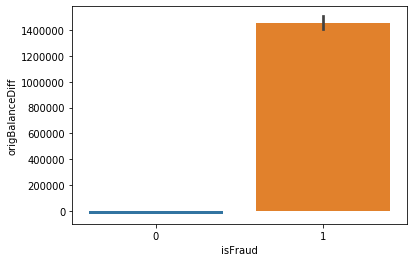

In [15]:
fd['origBalanceDiff'] = fd['oldbalanceOrig'] - fd['newbalanceOrig']
sns.barplot(x='isFraud', y='origBalanceDiff', data=fd)

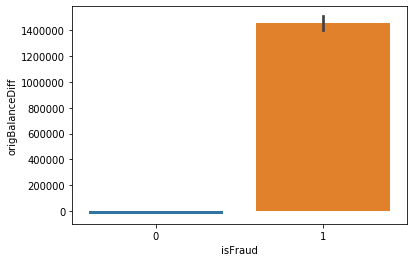

In [16]:
fd['destBalanceDiff'] = fd['newbalanceDest'] - fd['oldbalanceDest']
sns.barplot(x='isFraud', y='origBalanceDiff', data=fd)

## Feature Analysis

**To create a feature set:**  
  **1. use the balance difference of the original account**  
  **2. use the balance difference of the destination account**  
  **3. add a variable indicating destination account is a merchant or not**  
  **4. one hot encoding *Type* column**   

In [17]:
fd['nDes'] = fd['nameDest'].str.contains('M')

In [18]:
X = fd.drop(['nameOrig', 'nameDest'], axis=1)

In [19]:
type1 = pd.get_dummies(X['type'],drop_first=True)
X.drop(['type'],axis=1,inplace=True)
X = pd.concat([X,type1],axis=1)

y = X['isFraud']
X.drop('isFraud', axis=1,inplace=True)

## Predicting Model

**Decesion Tree Classifier**

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn import metrics

dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

print("Train accuracy score is ", metrics.accuracy_score(y_train, dtree.predict(X_train)))
print("Test accuracy score is ", metrics.accuracy_score(y_test, dtree.predict(X_test)))

Train accuracy score is  1.0
Test accuracy score is  0.9997040003436739


In [22]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,dtree.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906369
           1       0.89      0.88      0.88      2417

    accuracy                           1.00   1908786
   macro avg       0.94      0.94      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786



**There aren't any assumptions made for Decesion Tree Classifier since it's a classification method, not a regression one.**  
**Good estimation result using Decesion Tree Classifier, the depth of the tree is 35 so too large to present.**

### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

print("Train accuracy score is ", metrics.accuracy_score(y_train, rfc.predict(X_train)))
print("Test accuracy score is ", metrics.accuracy_score(y_test, rfc.predict(X_test)))

Train accuracy score is  1.0
Test accuracy score is  0.9997239082851613


In [25]:
print(classification_report(y_test,rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906369
           1       0.98      0.80      0.88      2417

    accuracy                           1.00   1908786
   macro avg       0.99      0.90      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786



**There aren't any assumptions made for Random Forest.**  
**The Train accuracy is no longer 100%, which prevents the model from overfitting, leads to a potentially better fit than Decesion Tree Classifier.**